# Data Wrangling on Amazon Fine Food Review dataset

## Import Required Modules

In [13]:
import os # for file handling
import sqlite3 # for database handling
from pathlib import Path # for file management
import pandas as pd # for handling data as frames
import numpy as np # for matrix processing
import csv # for CSV file handling
#from tqdm import tqdm_notebook
from tqdm import tqdm # for tracking the execution progress
import re # for regular expression over sentences for pre-processing
from nltk.corpus import stopwords # for stopwords removal
import string  # for punctuation mark list

from sklearn.feature_extraction.text import CountVectorizer # for Bag Of Words
from sklearn.feature_extraction.text import TfidfVectorizer # for text to vector creation
from gensim.models import Word2Vec # For Word2Vec
#from sklearn.preprocessing import StandardScaler # for Column Standardization
from sklearn.preprocessing import MinMaxScaler # for Row Standardization

from sklearn.decomposition import TruncatedSVD # for reducing Bow/TFIDF dimension

import scipy.sparse # for storing sparse matrix

import pickle # for storing review polarities

import nltk # for pre-processing text data
nltk.download('stopwords')

from prettytable import PrettyTable # for pretty table
from matplotlib import pyplot as plt # for pie char

[nltk_data] Downloading package stopwords to C:\Users\yuvaraja
[nltk_data]     manikandan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# All the outputs generated by this notebook will be placed in a separate folder
output_dir = 'Output'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
def getOutputFileNamePath(file_name):
    return str(Path.cwd() / output_dir / file_name)

def saveListToFile(file_name, my_list):
    '''
    Helper function to save the given list into a file
    Each item is considered as a string and stored in a separate line
    '''
    with open(getOutputFileNamePath(file_name), 'w') as f:
        for item in my_list:
            f.write("%s\n" % item)
            
def storeSet(w_set, file_name):
    with open(getOutputFileNamePath(file_name), 'w', encoding="utf-8") as csv_file:
        for w in w_set:
            csv_file.write(str(w))
            csv_file.write('\n')
            
            
# https://stats.stackexchange.com/questions/340933/truncatedsvd-always-reduces-dataset-to-1d
def GetRandomizedSVD(**kwargs):
    '''
    Common function wtih fixed SVD configuration for TruncatedSVD
    '''
    return TruncatedSVD(algorithm='randomized',
                        random_state=42,
                        **kwargs)

def GetOptimalDimension(X,req_variance=0.95):
    '''
    Function to get dimension on SVD having 95% variance
    Input:
        X: Numpy Array of the data
        req_variance - Require varianced (default 0.95)
    Output:
        Max dimensions after SVD that is needed to have the requested variance
    '''

    max_svd_components = X.get_shape()[1] - 1
    print('GetOptimalDimension -> Actual: ', X.get_shape()[1], ' Selected: ', max_svd_components)
    svd = GetRandomizedSVD(n_components=max_svd_components)
    svd.fit(X)
    cumsum = np.cumsum(svd.explained_variance_ratio_)
    max_svd_components = np.argmax(cumsum >= req_variance) + 1
    print('GetOptimalDimension -> Final SVD Component Size: ', max_svd_components)
    #print('Cum Var: ', cumsum)
    
    return max_svd_components
    
    '''
    print('Final SVD Component Size: ', max_svd_components, 'Cum Var: ', cumsum)

    svd = get_svd(n_components=max_svd_components)
    return svd.fit_transform(X)
    '''

# Load Data

In [3]:
# Using sqlite read data from the database
#con = sqlite3.connect('/content/drive/My Drive/Colab Notebooks/AFF-Review/database.sqlite')
db_path = Path.cwd() / 'database.sqlite'
con = sqlite3.connect(str(db_path))

# Get reviews which do not have score as 3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Insights about Data (Highlevel Statistics)

Let me try to understand the dataset that is given to me (Basically 'Understanding the Data')

In [4]:
filtered_data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,525814.000000,525814.000000,525814.000000,525814.000000,5.258140e+05
mean,284599.060038,1.747293,2.209544,4.279148,1.295943e+09
std,163984.038077,7.575819,8.195329,1.316725,4.828129e+07
min,1.000000,0.000000,0.000000,1.000000,9.393408e+08
25%,142730.250000,0.000000,0.000000,4.000000,1.270598e+09
50%,284989.500000,0.000000,1.000000,5.000000,1.310861e+09
75%,426446.750000,2.000000,2.000000,5.000000,1.332634e+09
max,568454.000000,866.000000,878.000000,5.000000,1.351210e+09


## Features/ Labels

In [5]:
print(filtered_data.columns)
print(filtered_data.dtypes)

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')
Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object


### Observation
- Totally 10 features given
- No labels given
- From Kaggle below information I have obtained about teach feature
  - https://www.kaggle.com/snap/amazon-fine-food-reviews
- Id
  - Row Id
- ProductId
  - Unique identifier for the product
- UserId
  - Unqiue identifier for the user
- ProfileName
  - Profile name of the user
- HelpfulnessNumerator
  - Number of users who found the review helpful
- HelpfulnessDenominator
  - Number of users who indicated whether they found the review helpful
- Score
  - Rating between 1 and 5
- Time
  - Timestamp for the review
- Summary
  - Brief summary of the review
- Text
  - Text of the review

# Data Cleaning

Since it is a text corpus, before feature creation, data neet to be cleaned.

I have executed this stage in two steps

1. First analyse the give data for abnormality
2. Execute the cleaning process based on previous step observations

## Analysis

### Features Analysis

In [6]:
# Id
u = filtered_data.Id.value_counts()
u.unique()

array([1], dtype=int64)

In [7]:
# ProductId
len(filtered_data.ProductId.unique())

72005

In [8]:
# UserId
len(filtered_data.UserId.unique())

243414

In [9]:
# HelpfulnessNumerator
print(filtered_data.HelpfulnessNumerator.min(),
      filtered_data.HelpfulnessNumerator.max(),
      len(filtered_data.HelpfulnessNumerator.unique()))

0 866 222


In [10]:
# HelpfulnessDenominator
print(filtered_data.HelpfulnessDenominator.min(),
      filtered_data.HelpfulnessDenominator.max(),
      len(filtered_data.HelpfulnessDenominator.unique()))

# As per feature details, Denominator should be greater than Numerator
# Lets check whether the data follows that description
filtered_data[(filtered_data.HelpfulnessDenominator < filtered_data.HelpfulnessNumerator)]

0 878 227


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
59301,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [11]:
# Score
print(filtered_data.Score.unique())
print(filtered_data.Score.value_counts())

[5 1 4 2]
5    363122
4     80655
1     52268
2     29769
Name: Score, dtype: int64


In [12]:
# Time
print(len(filtered_data.Time.unique()))
#filtered_data['Time'].value_counts()

# Check whether any entry with same time for more than one product
# which is practically not possible
userid_group = filtered_data.groupby('UserId')
#g = userid_group.groups
#g.values()

fil_val = userid_group.filter(lambda x:len(x)>1).sort_values('Time')
fil_val.to_csv(getOutputFileNamePath('user_id_grouped.csv'))
fil_val.head()

3157


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,5,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...
417927,451949,B00004CXX9,A1048CYU0OV4O8,Judy L. Eans,2,2,5,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...


### Invalid Review check / Analysis - on Summary

In [13]:
def getEntriesHavingWords(df, col_to_search, regex_list):
    '''
    Function to search for given list of regex expressions over the requested column
    '''
    indices = []
    counts = []
    for regex_val in regex_list:
        l = df[df[col_to_search].str.contains(regex_val,regex=True)].index.tolist()
        counts.append(len(l))
        indices = indices + l
    return indices, counts

In [14]:
text_list = ['Tim Burton', r'\b[bB]ook\b', r'\b[fF]ilm\b']
suspicious_indices, counts = getEntriesHavingWords(filtered_data,
                                       'Summary',
                                       text_list)

for i in range(len(counts)):
    print("No. of entries having '{0}' is {1}".format(text_list[i], counts[i]))

print('Total suspicious entries : ', len(suspicious_indices))
save_data = filtered_data.iloc[suspicious_indices]
save_data.to_csv(getOutputFileNamePath('non_related_review_entries.csv'))
save_data.head()

No. of entries having 'Tim Burton' is 36
No. of entries having '\b[bB]ook\b' is 58
No. of entries having '\b[fF]ilm\b' is 17
Total suspicious entries :  111


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
212391,230200,B00004RYGX,A2H1WNB30JNAWU,Jack D. Lowry,0,0,5,1345939200,One of Tim Burton's best movies,Beetlejuice one of Tim Burton's best movies he...
212417,230228,B00004RYGX,ASJ54MITON1NO,"Dr. Feelgood ""Dr. Feelgood""",0,0,5,1254873600,"1988 Tim Burton film, dvd.","Tim Burton's unique vision, which is almost ca..."
212423,230234,B00004RYGX,A1FMJJKSVQDDQ,Eric S. Kim,0,0,4,1224460800,Tim Burton's imagination goes wild!,I'd have to say that this isn't really a top f...
212439,230250,B00004RYGX,A1TW9ZGRDQQZ2Y,Monkdude,0,0,5,1109635200,One of Tim Burton's earliest and best films,Edited this review on 10/28/08.<br /><br />Eve...
212444,230255,B00004RYGX,A1JZV9MCT6KOX4,"C. Eallonardo ""Kali's Copilot""",0,0,5,1037923200,Good Tim Burton Flick,I like Tim Burton movies in general. But this...


### Invalid Entry check /  analysis - on review text

Since checking this process takes long time,
after this check,
I have disabled this code to avoid huge delay in  pre-processing

In [52]:
def getUniqueWords(df, col_name):
    words = [w for index,row in df[col_name].items() for w in row.split()]
    return list(set(words))

In [53]:
%%time
summary_words = getUniqueWords(filtered_data, 'Summary')

Wall time: 479 ms


In [54]:
%%time
text_words = getUniqueWords(filtered_data, 'Text')

Wall time: 9.43 s


In [55]:
print('Total unique words in Summary: ', len(summary_words))
print('Total unique words in Review Text: ', len(text_words))

Total unique words in Summary:  98264
Total unique words in Review Text:  553862


In [56]:
storeSet(summary_words, 'summary_words.csv')
storeSet(text_words, 'text_words.csv')

In [57]:
invalidChars = set(string.punctuation.replace("_", ""))

def containsAny(word, char_list):
    '''
    If any of the character in char_list found in 'word' will return True
    Otherwise returns False
    '''
    for c in char_list:
        if c in word:
            return True
    return False

def containsAll(word, char_list):
    '''
    If all of the characters in char_list found in 'word' will return True
    Otherwise returns False
    '''
    for c in char_list:
        if c not in word:
            return True
    return False

In [69]:
def getWordsHavingSpecialChar(df, col_name):
    '''
    Function to get list of words having special characters in the requested column
    '''
    words = []
    count  = 0
    for row in tqdm(df[col_name],ascii=True):
        w_c_l = []
        for w in row.split():
            if containsAny(w, invalidChars):
                words.append(w)
    return words

In [70]:
%%time
summary_invalid_words = getWordsHavingSpecialChar(filtered_data, 'Summary')

100%|######################################################################| 525814/525814 [00:03<00:00, 140180.76it/s]


Wall time: 3.76 s


In [71]:
%%time
text_invalid_words = getWordsHavingSpecialChar(filtered_data, 'Text')

100%|########################################################################| 525814/525814 [00:54<00:00, 9734.75it/s]


Wall time: 54 s


In [72]:
print('Total unique (invalid) words in Summary: ', len(summary_invalid_words))
print('Total unique (invalid) words in Review Text: ', len(text_invalid_words))

Total unique (invalid) words in Summary:  345554
Total unique (invalid) words in Review Text:  6728685


In [73]:
storeSet(summary_invalid_words, 'summary_invalid_words.csv')
storeSet(text_invalid_words, 'text_invalid_words.csv')

## Observation Summary

- Id
    - No Id repeation
- ProductId
    - 72005 Products
- UserId
    - 243414 Users
- HelpfulnessNumerator
    - value ranges from 0 to 808
    - 222 unique entries
- HelpfulnessDenominator
    - value ranges from 0 to 878
    - 227 unique entries
    - **2 invalid entries found**
      - Denominator is greater than Numerator
- Score
    - Scores range from 1 to 5 only
    - No invalid entries found
    - **No equal amount of data points for each score**
      - We have an __IMBALANCED__ dataset

- Entries with book/Book words found in text reviews
- Entries with film/Film words found in text reviews
- There are duplicates

## Cleaning

Actual cleaning process I am doing here

### Convert Score to Positive/Negative review

In [74]:
def ScoreToReviewType(score):
    if score < 3:
        return 0
    return 1

filtered_data.Score = filtered_data.Score.map(ScoreToReviewType)
print(filtered_data.Score.unique())

[1 0]


### Drop Duplicates

In [75]:
# Sort the data based on ProductID in ascending order so that we can keep only one kind of product review
sorted_data = filtered_data.sort_values('Time',axis=0, ascending=True, inplace=False, na_position='last')

In [76]:
# keep first entry, drop remaining duplicate entries
final_data = sorted_data.drop_duplicates(subset={'UserId','Time'},keep='first',inplace=False)
print(final_data.shape)

(328732, 10)


In [77]:
# Cross-checking for NaN removal
final_data.isnull().sum().sum()

0

### Remove Invalid Helpfull Score entries

In [78]:
# Drop data having invalid helpful score entries
# that is removing entries which has denominator greater than numerator, which is practically impossible
final_data = final_data[final_data.HelpfulnessNumerator <= final_data.HelpfulnessDenominator]
print(final_data.shape)

(328731, 10)


### Remove Invalid Summary Entries

- Remove actual film reviews
- Tim Burton (found by filtering film words and looking into data)

In [79]:
# Remove reviews unrelated to foods

text_list = ['Tim Burton', r'\b[bB]ook\b', r'\b[fF]ilm\b']
suspicious_indices, counts = getEntriesHavingWords(final_data,
                                       'Summary',
                                       text_list)

final_data = final_data.drop(suspicious_indices)
print(final_data.shape)

(328674, 10)


### Remove Invalid Text (Review) Entries

In [80]:
# Remove film reviews found in Review Text
final_data = final_data[~final_data.Text.str.contains('Tim Burton')]
print(final_data.shape)

(328622, 10)


In [81]:
def removeHtmlTags(sentence):
    '''
    function to remove HTML tags in the given sentence
    '''
    reg_exp = re.compile('<.*?>', )
    cleaned_text = re.sub(reg_exp, ' ', sentence)
    return cleaned_text

def removePunctuations(sentence):
    '''
    function to remove punctuations in the given sentence
    '''
    cleaned_sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned_sentence = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned_sentence)
    return cleaned_sentence

# s = 'Hi I am <pr> test </pr> testing'
# removeHtmlTags(s).split()

In [82]:
stop_words = set(stopwords.words('english')) # get stop words for English
#print(stop)
snow_stem = nltk.stem.SnowballStemmer('english') # get Stemmer for English
#print(snow)

In [83]:
# Creating final dataset set using/following steps

# 1. Removing HTML tags that are found in my above analysis
# 2. Removing punctuations, which has no meaning as a word
# 3. Stemming words based on English vocabulary set from NLTK
# 4. Creating a seperate list for both positive and negative cases, having only those words 

all_positive_words = []
all_negative_words = []
final_review_texts = []
df_index = 0 # for tracking the observations

for sent in tqdm(final_data['Text'].values,ascii=True):
    #print('{0} ==> '.format(df_index), sent)
    sent = removeHtmlTags(sent) # remove HTML tags first
    #print('{0} ==> '.format(df_index), sent)

    filtered_words = []
    for w in sent.split():
        #print(removePunctuations(w))
        for cleaned_word in removePunctuations(w).split():
            if ((cleaned_word.isalpha()) & (len(cleaned_word) > 2)):
                cleaned_word = cleaned_word.lower()
                #print(cleaned_word)
                if (cleaned_word not in stop_words):
                    s = (snow_stem.stem(cleaned_word)).encode('utf8')
                    filtered_words.append(s)
                    if ((final_data['Score'].values)[df_index] == 1):
                        all_positive_words.append(s)
                    else:
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue
        
    filtered_sent = b" ".join(filtered_words)
    #print(filtered_words, filtered_sent)
    final_review_texts.append(filtered_sent)

    df_index += 1
    #if df_index > 10:
        #break


100%|#########################################################################| 328622/328622 [06:31<00:00, 840.06it/s]


# Store cleaned data

In [84]:
len(final_review_texts)

328622

In [85]:
# add cleaned text as a seperate column (feature) into our final data dataframe
# It will easy me in handling the cleaned data

final_data['CleanedText'] = final_review_texts
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...
417927,451949,B00004CXX9,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,b'one movi movi collect fill comedi action wha...
417847,451864,B00004CXX9,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",b'alway enjoy movi funni entertain didnt hesit...


In [86]:
# Sort data based on Time
sorted_data = final_data.sort_values('Time',axis=0, ascending=True, inplace=False, na_position='last')

In [87]:
print(len(sorted_data))
sorted_data.head()

328622


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...
417927,451949,B00004CXX9,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,b'one movi movi collect fill comedi action wha...
417847,451864,B00004CXX9,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",b'alway enjoy movi funni entertain didnt hesit...


In [88]:
# store final data into new database
conn = sqlite3.connect(getOutputFileNamePath('cleaned.sqlite'))
c = conn.cursor()
conn.text_factory = str
sorted_data.to_sql('Reviews', conn, schema=None, if_exists='replace', 
                  index=True, index_label=None, dtype=None)
conn.close()

In [89]:
# Store review polarities in a seperate file
with open(getOutputFileNamePath('positive_words.pkl'), 'wb') as f:
    pickle.dump(all_positive_words, f)
    
with open(getOutputFileNamePath('negative_words.pkl'), 'wb') as f:
    pickle.dump(all_negative_words, f)

In [90]:
def getUniqueWords_2(df, col_name):
    words = [w for index,row in df[col_name].items() for w in row.decode('utf-8').split()]
    return list(set(words))

In [91]:
%%time

# How many unique words do we have in cleaned text?
text_words_cleaned = getUniqueWords_2(sorted_data, 'CleanedText')
print('Total unique words in Cleaned Text: ', len(text_words_cleaned))
storeSet(text_words_cleaned, 'cleanded_text_words.csv')

Total unique words in Cleaned Text:  68864
Wall time: 3.06 s


In [92]:
storeSet(text_words_cleaned, 'cleanded_text_words.csv')

In [98]:
def getWordsHavingSpecialChar_2(df, col_name):
    '''
    Function to get list of words having special characters in the requested column
    '''
    words = []
    count  = 0
    for row in tqdm(df[col_name],ascii=True):
        for w in row.decode('utf-8').split():
            if containsAny(w, invalidChars):
                words.append(w)
    return words

In [99]:
%%time

# Do we have any invalid words still in cleaned text?
text_invalid_words_cleanded = getWordsHavingSpecialChar_2(sorted_data, 'CleanedText')
print('Total unique (invalid) words in Cleaned Text: ', len(text_invalid_words_cleanded))
storeSet(text_invalid_words_cleanded, 'cleanded_invalid_text_words.csv')

100%|#######################################################################| 328622/328622 [00:17<00:00, 18492.56it/s]


Total unique (invalid) words in Cleaned Text:  0
Wall time: 17.8 s


# Data Set Preparation (splitting)

- We have approximately 328K reviews sorted according to its entry timestamp
- Due to memory limitation, I will be taking first 100K Reviews for Study
- Selected dataset will be splitted into:
    - First 60% as Training Data set
    - Next 20% as Cross Validation Data set
    - Remaining 20% as Test Data Set

In [3]:
total_entries = 150 * 1000 # 150K

n_train_entries = int(total_entries * 0.60)
n_cv_entries = int(total_entries * 0.20)
n_test_entries = int(total_entries * 0.20)

print('Train {0}, CV {1}, Test {2}, Total {3}'.format(n_train_entries, n_cv_entries, n_test_entries, total_entries))

Train 90000, CV 30000, Test 30000, Total 150000


In [4]:
con = sqlite3.connect(getOutputFileNamePath('cleaned.sqlite'))
df = pd.read_sql_query("""SELECT * from Reviews""", con)
df.head()
con.close()

In [5]:
# Creating Total DataSet
total_dataset = df.iloc[:total_entries]
#total_dataset = df.sample(n=total_entries,random_state=42)
print(total_dataset.shape)
total_dataset.head()

(150000, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
1,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
2,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...
3,417927,451949,B00004CXX9,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,b'one movi movi collect fill comedi action wha...
4,417847,451864,B00004CXX9,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",b'alway enjoy movi funni entertain didnt hesit...


In [6]:
# Sort dataset based on Time
total_dataset = total_dataset.sort_values('Time',axis=0, ascending=True, inplace=False, na_position='last')
total_dataset.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
1,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
2,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...
3,417927,451949,B00004CXX9,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,b'one movi movi collect fill comedi action wha...
4,417847,451864,B00004CXX9,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",b'alway enjoy movi funni entertain didnt hesit...


In [7]:
# Creating Training Dataset
train_dataset = total_dataset.iloc[:n_train_entries]
print(train_dataset.shape)
train_dataset.head()

(90000, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
1,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
2,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...
3,417927,451949,B00004CXX9,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,b'one movi movi collect fill comedi action wha...
4,417847,451864,B00004CXX9,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",b'alway enjoy movi funni entertain didnt hesit...


In [8]:
# Creating Cross Validation Dataset
cv_dataset = total_dataset.iloc[n_train_entries:(n_train_entries+n_cv_entries)]
print(cv_dataset.shape)
cv_dataset.head()

(30000, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
89923,272268,295091,B002GPG6BE,AVT5YM077UHFE,Vicki R. Boggs,1,1,1,1276560000,Rice Milk is available at Amazon.com!,"<a href=""http://www.amazon.com/gp/product/B002...",b'imagin rice dream drink enrich origin box pa...
89918,378488,409246,B003750AGE,AQS57P332FTEG,Van Gogh,0,4,0,1276560000,Grillin beans,These beans lacked flavor and I added a whole ...,b'bean lack flavor ad whole lot ingriedi make ...
90073,337369,365031,B001AC67DQ,A1270OOH9URZW4,KDragon,1,1,1,1276646400,Great Marinade,Love the taste! Sweet mesquite. Works great as...,b'love tast sweet mesquit work great marinad b...
90074,406009,439058,B000NY31EA,A3OQ3LTW5OTHP1,Peg B.,3,3,1,1276646400,If you could eat memories.....,I used this product to make hamburgers and the...,b'use product make hamburg tast like grandmoth...
90075,224408,243340,B00305L330,A2B117UIX7AJOA,L. Meaux,0,0,1,1276646400,Click-tastic!!,"So, I am always on the lookout for a good qual...",b'alway lookout good qualiti tasti protein per...


In [9]:
# Creating Test Dataset
test_dataset = total_dataset.iloc[(n_train_entries+n_cv_entries):]
print(test_dataset.shape)
test_dataset.head()

(30000, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
120084,249105,270074,B000LRIFU4,A34RLIHYRNS32O,Eileen,1,1,1,1293926400,best yeast ever,this works. anyone who's ever baked with yeast...,b'work anyon whos ever bake yeast know horror ...
120073,394347,426432,B000I62E82,A2X4F1HB3GUKWU,Red Writer,0,0,1,1293926400,Oregon Fruit Boysenberries,I can always count on Oregon Fruit for the bes...,b'alway count oregon fruit best boysenberri pi...
120004,329113,356190,B0018RYBZ4,A2I3Q8D73940OC,MichiganMommy,0,0,1,1293926400,Doesn't get any better than this,At 13 weeks into my pregnancy I found out I ha...,b'week pregnanc found gestat diabet week sever...
119900,438189,473861,B000FPDYR6,A2N9HNTRR1ZDZG,"SV ""TeaRific""",0,1,1,1293926400,words are not enough - groans of pleasure best...,A checker snorted at seeing this product. I to...,b'checker snort see product told allergi often...
120002,417520,451524,B001M0503E,A16D04BXWBATFS,Jack Jericho,0,0,1,1293926400,Delicious,"I'm a strawberry lover, I'll eat anything stra...",b'strawberri lover ill eat anyth strawberri de...


+---------+-------+------------------+------------------+---------------+
| DataSet | Total | Postivie Reviews | Negative Reviews |     Ratio     |
+---------+-------+------------------+------------------+---------------+
|  Train  | 90000 |      78845       |      11155       | 0.876 : 0.124 |
|    CV   | 30000 |      25062       |       4938       | 0.835 : 0.165 |
|   Test  | 30000 |      25020       |       4980       | 0.834 : 0.166 |
+---------+-------+------------------+------------------+---------------+


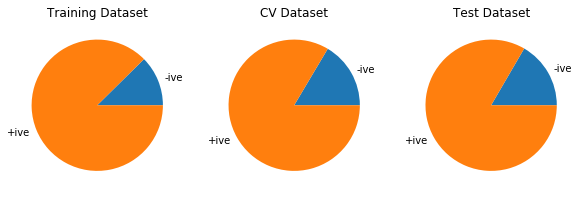

In [15]:
# What is balance of review polarity in our dataset(s)?
class_ratio = PrettyTable()
class_ratio.field_names = ["DataSet", "Total", "Postivie Reviews", "Negative Reviews", "Ratio"]
plt.figure(figsize=(10,10))

pos_rev_count = train_dataset[train_dataset.Score == 1].Score.value_counts().tolist()[0]
neg_rev_count = train_dataset[train_dataset.Score == 0].Score.value_counts().tolist()[0]
ratio = '{0} : {1}'.format(round(pos_rev_count/len(train_dataset),3),round(neg_rev_count/len(train_dataset),3))
class_ratio.add_row(['Train', len(train_dataset), pos_rev_count, neg_rev_count, ratio])
plt.subplot(1,3,1)
plt.pie([neg_rev_count, pos_rev_count], labels=['-ive', '+ive']);
plt.title('Training Dataset');

pos_rev_count = cv_dataset[cv_dataset.Score == 1].Score.value_counts().tolist()[0]
neg_rev_count = cv_dataset[cv_dataset.Score == 0].Score.value_counts().tolist()[0]
ratio = '{0} : {1}'.format(round(pos_rev_count/len(cv_dataset),3),round(neg_rev_count/len(cv_dataset),3))
class_ratio.add_row(['CV', len(cv_dataset), pos_rev_count, neg_rev_count, ratio])
plt.subplot(1,3,2)
plt.pie([neg_rev_count, pos_rev_count], labels=['-ive', '+ive']);
plt.title('CV Dataset');

pos_rev_count = test_dataset[test_dataset.Score == 1].Score.value_counts().tolist()[0]
neg_rev_count = test_dataset[test_dataset.Score == 0].Score.value_counts().tolist()[0]
ratio = '{0} : {1}'.format(round(pos_rev_count/len(test_dataset),3),round(neg_rev_count/len(test_dataset),3))
class_ratio.add_row(['Test', len(test_dataset), pos_rev_count, neg_rev_count, ratio])
plt.subplot(1,3,3)
plt.pie([neg_rev_count, pos_rev_count], labels=['-ive', '+ive']);
plt.title('Test Dataset');

print(class_ratio)

## Bag of Words Sparse Matrix

- Create BoW Vectorizer Model with:
    - min word frequency of 30
    - considering both uni-gram and bi-gram words
    - of maximum 3000 features
- Fit Training Data to the BoW Model
- For each dataset (Training, Cross-Validataion and Test)
    - Transform DataSet using the trained model
    - Store the Transformed data
    - Row Normalize the Training Data
    - Store the Row Normalized data in a separate file

In [170]:
def genBowDataSets():
    '''
    Generates BoW Vectors for Training, CV and Test datasets
    '''
    #################################
    # Vectorizing  Training Dataset #
    #################################
    print('Generating Training Dataset')
    data_array = train_dataset['CleanedText']
    label_array = train_dataset['Score']
    file_prefix = 'Train'

    label_file_name = getOutputFileNamePath('{0}_bow_label'.format(file_prefix))
    vec_file_name = getOutputFileNamePath('{0}_bow'.format(file_prefix))
    vec_svd_file_name = getOutputFileNamePath('{0}_bow_svd'.format(file_prefix))
    ved_std_file_name = getOutputFileNamePath('{0}_bow_std'.format(file_prefix))

    # Store Label as a separate file
    scipy.sparse.save_npz(label_file_name, scipy.sparse.csr_matrix(label_array))

    # Train the Model
    bow_model = CountVectorizer(min_df=30, max_features=2500, ngram_range=(1,2))
    bow_vectorizer = bow_model.fit(data_array)

    bow_vector = bow_vectorizer.transform(data_array)
    print('Shape of BoW Vectorizer: ', bow_vector.get_shape())
    print('Total no.of unique words: ', bow_vector.get_shape()[1])
    scipy.sparse.save_npz(vec_file_name, scipy.sparse.csr_matrix(bow_vector))
    
    # Reduce dimensionality using TruncatedSVD
    max_svd_components = GetOptimalDimension(bow_vector)
    svd_model = GetRandomizedSVD(n_components=max_svd_components)
    svd_model = svd_model.fit(bow_vector)
    svd_data = svd_model.transform(bow_vector)
    scipy.sparse.save_npz(vec_svd_file_name, scipy.sparse.csr_matrix(svd_data))

    # Row-Normalize the Data
    scaler_model = MinMaxScaler()
    scaler_data = bow_vector.todense().astype(np.float64).T
    scaler_model = scaler_model.fit(scaler_data)
    scaler_data = scaler_model.transform(scaler_data)
    scaler_data = scaler_data.T
    print('Shape of Scaled data', scaler_data.shape)
    scipy.sparse.save_npz(ved_std_file_name, scipy.sparse.csr_matrix(scaler_data))
    
    ##########################
    # Vectorizing CV Dataset #
    ##########################
    print('\nGenerating CV Dataset')
    data_array = cv_dataset['CleanedText']
    label_array = cv_dataset['Score']
    file_prefix = 'CV'

    label_file_name = getOutputFileNamePath('{0}_bow_label'.format(file_prefix))
    vec_file_name = getOutputFileNamePath('{0}_bow'.format(file_prefix))
    vec_svd_file_name = getOutputFileNamePath('{0}_bow_svd'.format(file_prefix))
    ved_std_file_name = getOutputFileNamePath('{0}_bow_std'.format(file_prefix))

    # Store Label as a separate file
    scipy.sparse.save_npz(label_file_name, scipy.sparse.csr_matrix(label_array))

    # Transform the Dataset using fitted model
    bow_vector = bow_vectorizer.transform(data_array)
    print('Shape of BoW Vectorizer: ', bow_vector.get_shape())
    print('Total no.of unique words: ', bow_vector.get_shape()[1])
    scipy.sparse.save_npz(vec_file_name, scipy.sparse.csr_matrix(bow_vector))
    
    # Reduce dimensionality using TruncatedSVD
    svd_data = svd_model.transform(bow_vector)
    scipy.sparse.save_npz(vec_svd_file_name, scipy.sparse.csr_matrix(svd_data))

    # Row-Normalize the Data
    scaler_model = MinMaxScaler()
    scaler_data = bow_vector.todense().astype(np.float64).T
    scaler_model = scaler_model.fit(scaler_data)
    scaler_data = scaler_model.transform(scaler_data)
    scaler_data = scaler_data.T
    print('Shape of Scaled data', scaler_data.shape)
    scipy.sparse.save_npz(ved_std_file_name, scipy.sparse.csr_matrix(scaler_data))

    
    ############################
    # Vectorizing Test Dataset #
    ############################
    print('\nGenerating Test Dataset')
    data_array = test_dataset['CleanedText']
    label_array = test_dataset['Score']
    file_prefix = 'Test'

    label_file_name = getOutputFileNamePath('{0}_bow_label'.format(file_prefix))
    vec_file_name = getOutputFileNamePath('{0}_bow'.format(file_prefix))
    vec_svd_file_name = getOutputFileNamePath('{0}_bow_svd'.format(file_prefix))
    ved_std_file_name = getOutputFileNamePath('{0}_bow_std'.format(file_prefix))

    # Store Label as a separate file
    scipy.sparse.save_npz(label_file_name, scipy.sparse.csr_matrix(label_array))

    # Transform the Dataset using fitted model
    bow_vector = bow_vectorizer.transform(data_array)
    print('Shape of BoW Vectorizer: ', bow_vector.get_shape())
    print('Total no.of unique words: ', bow_vector.get_shape()[1])
    scipy.sparse.save_npz(vec_file_name, scipy.sparse.csr_matrix(bow_vector))
    
    # Reduce dimensionality using TruncatedSVD
    svd_data = svd_model.transform(bow_vector)
    scipy.sparse.save_npz(vec_svd_file_name, scipy.sparse.csr_matrix(svd_data))

    # Row-Normalize the Data
    scaler_model = MinMaxScaler()
    scaler_data = bow_vector.todense().astype(np.float64).T
    scaler_model = scaler_model.fit(scaler_data)
    scaler_data = scaler_model.transform(scaler_data)
    scaler_data = scaler_data.T
    print('Shape of Scaled data', scaler_data.shape)
    scipy.sparse.save_npz(ved_std_file_name, scipy.sparse.csr_matrix(scaler_data))

In [171]:
%%time

genBowDataSets()

Generating Training Dataset
Shape of BoW Vectorizer:  (90000, 2500)
Total no.of unique words:  2500
GetOptimalDimension -> Actual:  2500  Selected:  2499
GetOptimalDimension -> Final SVD Component Size:  1537
Shape of Scaled data (90000, 2500)

Generating CV Dataset
Shape of BoW Vectorizer:  (30000, 2500)
Total no.of unique words:  2500
Shape of Scaled data (30000, 2500)

Generating Test Dataset
Shape of BoW Vectorizer:  (30000, 2500)
Total no.of unique words:  2500
Shape of Scaled data (30000, 2500)
Wall time: 6min 7s


## TF-IDF Sparse Matrix

In [179]:
def genTfIdfDataSets():
    '''
    Generates TF-IDF Vectors for Training, CV and Test datasets
    '''
    #################################
    # Vectorizing  Training Dataset #
    #################################
    print('Generating Training Dataset')
    data_array = train_dataset['CleanedText']
    label_array = train_dataset['Score']
    file_prefix = 'Train'

    label_file_name = getOutputFileNamePath('{0}_tfidf_label'.format(file_prefix))
    vec_file_name = getOutputFileNamePath('{0}_tfidf'.format(file_prefix))
    vec_svd_file_name = getOutputFileNamePath('{0}_tfid_svd'.format(file_prefix))
    ved_std_file_name = getOutputFileNamePath('{0}_tfidf_std'.format(file_prefix))

    # Store Label as a separate file
    scipy.sparse.save_npz(label_file_name, scipy.sparse.csr_matrix(label_array))

    # Train the Model
    tfidf_model = TfidfVectorizer(min_df=30, max_features=2000, ngram_range=(1,2))
    tfidf_vectorizer = tfidf_model.fit(data_array)

    tfidf_vector = tfidf_vectorizer.transform(data_array)
    print('Shape of TfIDF Vectorizer: ', tfidf_vector.get_shape())
    print('Total no.of unique words: ', tfidf_vector.get_shape()[1])
    scipy.sparse.save_npz(vec_file_name, scipy.sparse.csr_matrix(tfidf_vector))

    
    # Reduce dimensionality using TruncatedSVD
    max_svd_components = GetOptimalDimension(tfidf_vector)
    svd_model = GetRandomizedSVD(n_components=max_svd_components)
    svd_model = svd_model.fit(tfidf_vector)
    svd_data = svd_model.transform(tfidf_vector)
    scipy.sparse.save_npz(vec_svd_file_name, scipy.sparse.csr_matrix(svd_data))

    # Row-Normalize the Data
    scaler_model = MinMaxScaler()
    scaler_data = tfidf_vector.todense().astype(np.float64).T
    scaler_model = scaler_model.fit(scaler_data)
    scaler_data = scaler_model.transform(scaler_data)
    scaler_data = scaler_data.T
    print('Shape of Scaled data', scaler_data.shape)
    scipy.sparse.save_npz(ved_std_file_name, scipy.sparse.csr_matrix(scaler_data))
    
    ##########################
    # Vectorizing CV Dataset #
    ##########################
    print('\nGenerating CV Dataset')
    data_array = cv_dataset['CleanedText']
    label_array = cv_dataset['Score']
    file_prefix = 'CV'

    label_file_name = getOutputFileNamePath('{0}_tfidf_label'.format(file_prefix))
    vec_file_name = getOutputFileNamePath('{0}_tfidf'.format(file_prefix))
    vec_svd_file_name = getOutputFileNamePath('{0}_tfid_svd'.format(file_prefix))
    ved_std_file_name = getOutputFileNamePath('{0}_tfidf_std'.format(file_prefix))

    # Store Label as a separate file
    scipy.sparse.save_npz(label_file_name, scipy.sparse.csr_matrix(label_array))

    # Transform the Dataset using fitted model
    tfidf_vector = tfidf_vectorizer.transform(data_array)
    print('Shape of TfIDF Vectorizer: ', tfidf_vector.get_shape())
    print('Total no.of unique words: ', tfidf_vector.get_shape()[1])
    scipy.sparse.save_npz(vec_file_name, scipy.sparse.csr_matrix(tfidf_vector))

    # Reduce dimensionality using TruncatedSVD
    svd_data = svd_model.transform(tfidf_vector)
    scipy.sparse.save_npz(vec_svd_file_name, scipy.sparse.csr_matrix(svd_data))

    # Row-Normalize the Data
    scaler_model = MinMaxScaler()
    scaler_data = tfidf_vector.todense().astype(np.float64).T
    scaler_model = scaler_model.fit(scaler_data)
    scaler_data = scaler_model.transform(scaler_data)
    scaler_data = scaler_data.T
    print('Shape of Scaled data', scaler_data.shape)
    scipy.sparse.save_npz(ved_std_file_name, scipy.sparse.csr_matrix(scaler_data))
    
    ############################
    # Vectorizing Test Dataset #
    ############################
    print('\nGenerating Test Dataset')
    data_array = test_dataset['CleanedText']
    label_array = test_dataset['Score']
    file_prefix = 'Test'

    label_file_name = getOutputFileNamePath('{0}_tfidf_label'.format(file_prefix))
    vec_file_name = getOutputFileNamePath('{0}_tfidf'.format(file_prefix))
    vec_svd_file_name = getOutputFileNamePath('{0}_tfid_svd'.format(file_prefix))
    ved_std_file_name = getOutputFileNamePath('{0}_tfidf_std'.format(file_prefix))

    # Store Label as a separate file
    scipy.sparse.save_npz(label_file_name, scipy.sparse.csr_matrix(label_array))

    # Transform the Dataset using fitted model
    tfidf_vector = tfidf_vectorizer.transform(data_array)
    print('Shape of BoW Vectorizer: ', tfidf_vector.get_shape())
    print('Total no.of unique words: ', tfidf_vector.get_shape()[1])
    scipy.sparse.save_npz(vec_file_name, scipy.sparse.csr_matrix(tfidf_vector))

    # Reduce dimensionality using TruncatedSVD
    svd_data = svd_model.transform(tfidf_vector)
    scipy.sparse.save_npz(vec_svd_file_name, scipy.sparse.csr_matrix(svd_data))

    # Row-Normalize the Data
    scaler_model = MinMaxScaler()
    scaler_data = tfidf_vector.todense().astype(np.float64).T
    scaler_model = scaler_model.fit(scaler_data)
    scaler_data = scaler_model.transform(scaler_data)
    scaler_data = scaler_data.T
    print('Shape of Scaled data', scaler_data.shape)
    scipy.sparse.save_npz(ved_std_file_name, scipy.sparse.csr_matrix(scaler_data))

In [180]:
%%time

genTfIdfDataSets()

Generating Training Dataset
Shape of TfIDF Vectorizer:  (90000, 2000)
Total no.of unique words:  2000
GetOptimalDimension -> Actual:  2000  Selected:  1999
GetOptimalDimension -> Final SVD Component Size:  1606
Shape of Scaled data (90000, 2000)

Generating CV Dataset
Shape of TfIDF Vectorizer:  (30000, 2000)
Total no.of unique words:  2000
Shape of Scaled data (30000, 2000)

Generating Test Dataset
Shape of BoW Vectorizer:  (30000, 2000)
Total no.of unique words:  2000
Shape of Scaled data (30000, 2000)
Wall time: 5min 22s


## Avg Word2Vec

Max Dimension for Word2Vec = 50 (some arbitraty value, no calculation made on selecting this value)

In [181]:
def getListOfSentences(data_array):
    '''
    returns list having each sentence as an entry
    '''
    list_of_sent = []
    for sent in data_array:
        list_of_sent.append(sent.decode("utf-8").split())
    return list_of_sent

In [182]:
def getAvgW2VReviewVectors(w2v_model,data_array):
    '''
    returns the w2v for all the reviews that exist in data_array using w2v_vocab
    Input:
        w2v_model - Model which need to be used for vectorization
        data_array - Reviews that need to be vectorized
    Output:
        List having W2V Vectorized data for data_array
    '''
    list_of_sent = getListOfSentences(data_array)
    w2v_words = list(w2v_model.wv.vocab)
    #saveListToFile(file_prefix + '_avg_w2v_w2v_words',w2v_words)
    #print("number of words that occured minimum 5 times : ",len(w2v_words))
    #print("sample words ", w2v_words[0:50])

    # Computing average w2v for each review in selected training dataset
    review_vectors = []
    for sent in tqdm(list_of_sent, ascii=True):
        sent_vec = np.zeros(w2v_d) # array to hold the vectors. Initially assuming no vectors in this review
        no_of_words_in_review = 0 # number of words with valid vector in this review

        # count all the words (that are in w2v model) and take average
        for word in sent:
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                no_of_words_in_review += 1
        if no_of_words_in_review != 0:
            sent_vec /= no_of_words_in_review
        review_vectors.append(sent_vec)
        
    return review_vectors

In [183]:
# Required dimension
w2v_d = 50

In [184]:
def getAvgW2VDataSet():
    '''
    Generates Average Word2Vec Vector for Training, CV and Test datasets
    '''
    #################################
    # Vectorizing  Training Dataset #
    #################################
    print('Generating Training Dataset')
    data_array = train_dataset['CleanedText']
    label_array = train_dataset['Score']
    file_prefix = 'Train'

    label_file_name = getOutputFileNamePath('{0}_avg_w2v_label'.format(file_prefix))
    vec_file_name = getOutputFileNamePath('{0}_avg_w2v'.format(file_prefix))
    ved_std_file_name = getOutputFileNamePath('{0}_avg_w2v_std'.format(file_prefix))
    
    # Store Label as a separate file
    scipy.sparse.save_npz(label_file_name, scipy.sparse.csr_matrix(label_array.T))
    
    # Create Training DataSet List array for creating own W2V
    train_list_of_sent = getListOfSentences(data_array.values)
        
    # Considering words that are occured atleast 5 times in the corpus
    w2v_model = Word2Vec(train_list_of_sent, min_count=5, size=w2v_d, workers=16)

    # Computing average w2v for each review in selected training dataset
    review_vectors = getAvgW2VReviewVectors(w2v_model, data_array)
    np.save(vec_file_name, review_vectors)
    #print(len(review_vectors))
    #print(len(review_vectors[0]))
    
    # Row-Normalize the Data
    scaler_model = MinMaxScaler()
    scaler_data = np.array(review_vectors).astype(np.float64).T
    scaler_model = scaler_model.fit(scaler_data)
    scaler_data = scaler_model.transform(scaler_data)
    scaler_data = scaler_data.T
    print('Shape of Scaled data', scaler_data.shape)
    scipy.sparse.save_npz(ved_std_file_name, scipy.sparse.csr_matrix(scaler_data))
    
    ##########################
    # Vectorizing CV Dataset #
    ##########################
    print('\nGenerating CV Dataset')
    data_array = cv_dataset['CleanedText']
    label_array = cv_dataset['Score']
    file_prefix = 'CV'
    
    label_file_name = getOutputFileNamePath('{0}_avg_w2v_label'.format(file_prefix))
    vec_file_name = getOutputFileNamePath('{0}_avg_w2v'.format(file_prefix))
    ved_std_file_name = getOutputFileNamePath('{0}_avg_w2v_std'.format(file_prefix))
    
    # Store Label as a separate file
    scipy.sparse.save_npz(label_file_name, scipy.sparse.csr_matrix(label_array.T))
    
    # Computing average w2v for each review in selected training dataset
    review_vectors = getAvgW2VReviewVectors(w2v_model, data_array)
    np.save(vec_file_name, review_vectors)
    #print(len(review_vectors))
    #print(len(review_vectors[0]))
    
    # Row-Normalize the Data
    scaler_model = MinMaxScaler()
    scaler_data = np.array(review_vectors).astype(np.float64).T
    scaler_model = scaler_model.fit(scaler_data)
    scaler_data = scaler_model.transform(scaler_data)
    scaler_data = scaler_data.T
    print('Shape of Scaled data', scaler_data.shape)
    scipy.sparse.save_npz(ved_std_file_name, scipy.sparse.csr_matrix(scaler_data))
    
    ############################
    # Vectorizing Test Dataset #
    ############################
    print('\nGenerating Test Dataset')
    data_array = test_dataset['CleanedText']
    label_array = test_dataset['Score']
    file_prefix = 'Test'
    
    label_file_name = getOutputFileNamePath('{0}_avg_w2v_label'.format(file_prefix))
    vec_file_name = getOutputFileNamePath('{0}_avg_w2v'.format(file_prefix))
    ved_std_file_name = getOutputFileNamePath('{0}_avg_w2v_std'.format(file_prefix))
    
    # Store Label as a separate file
    scipy.sparse.save_npz(label_file_name, scipy.sparse.csr_matrix(label_array.T))
    
    # Computing average w2v for each review in selected training dataset
    review_vectors = getAvgW2VReviewVectors(w2v_model, data_array)
    np.save(vec_file_name, review_vectors)
    #print(len(review_vectors))
    #print(len(review_vectors[0]))
    
    # Row-Normalize the Data
    scaler_model = MinMaxScaler()
    scaler_data = np.array(review_vectors).astype(np.float64).T
    scaler_model = scaler_model.fit(scaler_data)
    scaler_data = scaler_model.transform(scaler_data)
    scaler_data = scaler_data.T
    print('Shape of Scaled data', scaler_data.shape)
    scipy.sparse.save_npz(ved_std_file_name, scipy.sparse.csr_matrix(scaler_data))
    return

In [185]:
%%time

getAvgW2VDataSet()

Generating Training Dataset


100%|##########################################################################| 90000/90000 [01:20<00:00, 1111.54it/s]


Shape of Scaled data (90000, 50)

Generating CV Dataset


100%|###########################################################################| 30000/30000 [00:30<00:00, 986.79it/s]


Shape of Scaled data (30000, 50)

Generating Test Dataset


100%|###########################################################################| 30000/30000 [00:33<00:00, 902.41it/s]


Shape of Scaled data (30000, 50)
Wall time: 2min 39s


## TF-IDF Weighted Word2Vec

Max Dimension for Word2Vec = 50 (some arbitraty value, no calculation made on selecting this value)

In [186]:
def getTFIDFWW2VReviewVectors(w2v_model,tf_idf_dict,data_array):
    '''
    returns the w2v for all the reviews that exist in data_array using w2v_vocab
    Input:
        w2v_model - Model which need to be used for vectorization
        tf_idf_dict - Dictionary having the vocabularies
        data_array - Reviews that need to be vectorized
    Output:
        List having W2V Vectorized data for data_array
    '''
    list_of_sent = getListOfSentences(data_array)
    w2v_words = list(w2v_model.wv.vocab)
    
    review_vectors = []
    for sent in tqdm(list_of_sent, ascii=True):
        sent_vec = np.zeros(w2v_d) # array to hold the vectors
        no_of_words_in_review = 0 # number of words with valid vector in this review

        # count all the words (that are in w2v model) and take average
        for word in sent:
            if word in w2v_words:
                vec = w2v_model.wv[word]
                # calculate tf-idf weighted w2v value for this word
                tf_idf = tf_idf_dict[word] * (sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                no_of_words_in_review += 1
        if no_of_words_in_review != 0:
            sent_vec /= no_of_words_in_review
        review_vectors.append(sent_vec)
    
    return review_vectors

In [187]:
def getTfIdfWeightedW2VDataset():
    '''
    Generates Average Word2Vec Vector for Training, CV and Test datasets
    '''
    #################################
    # Vectorizing  Training Dataset #
    #################################
    print('Generating Training Dataset')
    data_array = train_dataset['CleanedText']
    label_array = train_dataset['Score']
    file_prefix = 'Train'

    label_file_name = getOutputFileNamePath('{0}_tfidf_w_w2v_label'.format(file_prefix))
    vec_file_name = getOutputFileNamePath('{0}_tfidf_w_w2v'.format(file_prefix))
    ved_std_file_name = getOutputFileNamePath('{0}_tfidf_w_w2v_std'.format(file_prefix))
    
    # Store Label as a separate file
    scipy.sparse.save_npz(label_file_name, scipy.sparse.csr_matrix(label_array.T))
    
    # Create List array for creating own W2V
    train_list_of_sent = getListOfSentences(data_array.values)

    # Create tf-idf vector matrix
    tf_idf_model = TfidfVectorizer(ngram_range=(1,2))
    tf_idf_matrix = tf_idf_model.fit_transform(data_array.values)

    # Create dictionary having words (features) as keys, its tf-idf values as values
    tf_idf_dict = dict(zip(tf_idf_model.get_feature_names(), list(tf_idf_model.idf_)))
    len(tf_idf_dict)
    
    tf_idf_feat = tf_idf_model.get_feature_names()
    
    # Considering words that are occured atleast 5 times in the corpus
    w2v_model = Word2Vec(train_list_of_sent, min_count=5, size=w2v_d, workers=16)

    w2v_words = list(w2v_model.wv.vocab)
    #print("number of words that occured minimum 5 times : ",len(w2v_words))
    #print("sample words ", w2v_words[0:50])

    # Computing tf-idf weighted w2v for each review in selected training dataset
    review_vectors = getTFIDFWW2VReviewVectors(w2v_model, tf_idf_dict, data_array)
    np.save(vec_file_name, review_vectors)
    #print(len(review_vectors))
    #print(len(review_vectors[0]))
    
    # Row-Normalize the Data
    scaler_model = MinMaxScaler()
    scaler_data = np.array(review_vectors).astype(np.float64).T
    scaler_model = scaler_model.fit(scaler_data)
    scaler_data = scaler_model.transform(scaler_data)
    scaler_data = scaler_data.T
    print('Shape of Scaled data', scaler_data.shape)
    scipy.sparse.save_npz(ved_std_file_name, scipy.sparse.csr_matrix(scaler_data))
    
    ##########################
    # Vectorizing CV Dataset #
    ##########################
    print('\nGenerating CV Dataset')
    data_array = cv_dataset['CleanedText']
    label_array = cv_dataset['Score']
    file_prefix = 'CV'
    
    label_file_name = getOutputFileNamePath('{0}_tfidf_w_w2v_label'.format(file_prefix))
    vec_file_name = getOutputFileNamePath('{0}_tfidf_w_w2v'.format(file_prefix))
    ved_std_file_name = getOutputFileNamePath('{0}_tfidf_w_w2v_std'.format(file_prefix))
    
    # Store Label as a separate file
    scipy.sparse.save_npz(label_file_name, scipy.sparse.csr_matrix(label_array.T))
    
    # Computing tf-idf weighted w2v for each review in selected training dataset
    review_vectors = getTFIDFWW2VReviewVectors(w2v_model, tf_idf_dict, data_array)
    np.save(vec_file_name, review_vectors)
    
    # Row-Normalize the Data
    scaler_model = MinMaxScaler()
    scaler_data = np.array(review_vectors).astype(np.float64).T
    scaler_model = scaler_model.fit(scaler_data)
    scaler_data = scaler_model.transform(scaler_data)
    scaler_data = scaler_data.T
    print('Shape of Scaled data', scaler_data.shape)
    scipy.sparse.save_npz(ved_std_file_name, scipy.sparse.csr_matrix(scaler_data))
    
    ############################
    # Vectorizing Test Dataset #
    ############################
    print('\nGenerating Test Dataset')
    data_array = test_dataset['CleanedText']
    label_array = test_dataset['Score']
    file_prefix = 'Test'
    
    label_file_name = getOutputFileNamePath('{0}_tfidf_w_w2v_label'.format(file_prefix))
    vec_file_name = getOutputFileNamePath('{0}_tfidf_w_w2v'.format(file_prefix))
    ved_std_file_name = getOutputFileNamePath('{0}_tfidf_w_w2v_std'.format(file_prefix))
    
    # Store Label as a separate file
    scipy.sparse.save_npz(label_file_name, scipy.sparse.csr_matrix(label_array.T))
    
    # Computing tf-idf weighted w2v for each review in selected training dataset
    review_vectors = getTFIDFWW2VReviewVectors(w2v_model, tf_idf_dict, data_array)
    np.save(vec_file_name, review_vectors)
    
    # Row-Normalize the Data
    scaler_model = MinMaxScaler()
    scaler_data = np.array(review_vectors).astype(np.float64).T
    scaler_model = scaler_model.fit(scaler_data)
    scaler_data = scaler_model.transform(scaler_data)
    scaler_data = scaler_data.T
    print('Shape of Scaled data', scaler_data.shape)
    scipy.sparse.save_npz(ved_std_file_name, scipy.sparse.csr_matrix(scaler_data))
    
    return

In [188]:
%%time

getTfIdfWeightedW2VDataset()

Generating Training Dataset


100%|###########################################################################| 90000/90000 [02:17<00:00, 652.28it/s]


Shape of Scaled data (90000, 50)

Generating CV Dataset


100%|###########################################################################| 30000/30000 [00:51<00:00, 578.07it/s]


Shape of Scaled data (30000, 50)

Generating Test Dataset


100%|###########################################################################| 30000/30000 [01:08<00:00, 437.25it/s]


Shape of Scaled data (30000, 50)
Wall time: 4min 49s
